<a href="https://colab.research.google.com/github/evylegzhanin/Yandex_Profi_ML/blob/main/Final_Solution_with_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Введение.** 







Данный ноутбук содержит все подходы решений, которые были использованы при решении кейса в полуфинале олимпиады "Машинное обучение". 

**Содержание (по секциям):**
1.   Исследование тренировочного и тестового датасетов
2.   Кластеризация и усреднение
3.   Кригинг
4.   Генерация новых признаков и использование классических методов
5.   Stacking (с помощью мета-модели или модели второго уровня)
6.   Регрессионный кригинг
7.   Простейший stacking (усреднение результатов различных моделей)

# 1. Исследование исходных данных

Подключение необходимых библиотек:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm

Чтение тренировочного и тестового датасетов из файлов csv.

In [ ]:
train = pd.read_csv('Training_wells.csv')
test = pd.read_csv('Empty_part.csv')

Просмотр основной информации о датасетах.

In [ ]:
print('Train_info')
print(train.info())
print('='*50)
print('Test_info')
print(test.info())
print('='*50)
print('Train_describe')
print(train.describe())
print('='*50)
print('Test_describe')
print(test.describe())

Train_info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Well    138 non-null    object 
 1   X       138 non-null    int64  
 2   Y       138 non-null    int64  
 3   NTG     138 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ KB
None
Test_info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Well    1242 non-null   object
 1   X       1242 non-null   int64 
 2   Y       1242 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 29.2+ KB
None
Train_describe
                X           Y         NTG
count  138.000000  138.000000  138.000000
mean   223.195652  916.630435    0.325720
std     13.590926    8.765456    0.072432
min    201.000000  901.000000    0.177000
25%    211.000000  

Из двух датасетов уберем столбец "Well".

In [ ]:
train.drop('Well', axis=1, inplace=True)
test.drop('Well', axis=1, inplace=True)

Проверим корреляцию между признаками ("X", "Y") и целевой переменной ("NTG").

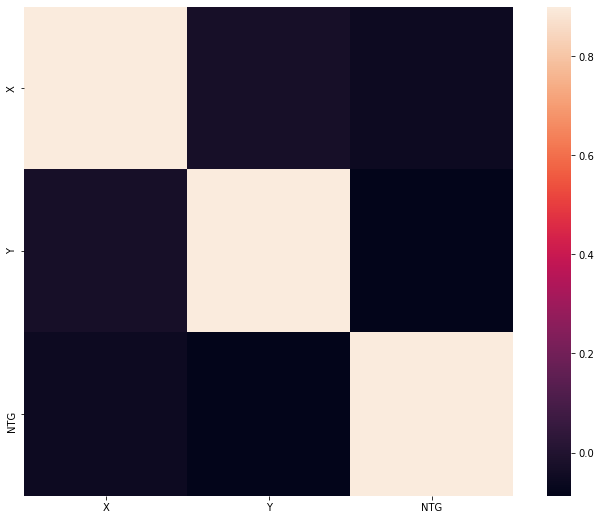

In [ ]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Предпологая, что признаки "X" и "Y" являются координатами скважин, построим карту скважин с известным параметром "NTG" (красный цвет) и скважин, которые предстоит исследовать (синиц цвет). 

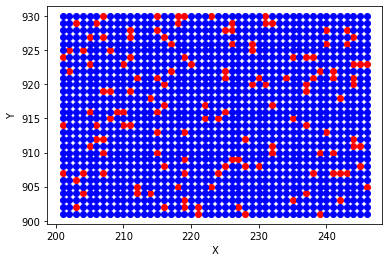

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['X'], y = train['Y'], c='r')
ax.scatter(x = test['X'], y = test['Y'], c='b')
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

Построим тепловую карту по известным значениям целевой переменной. 

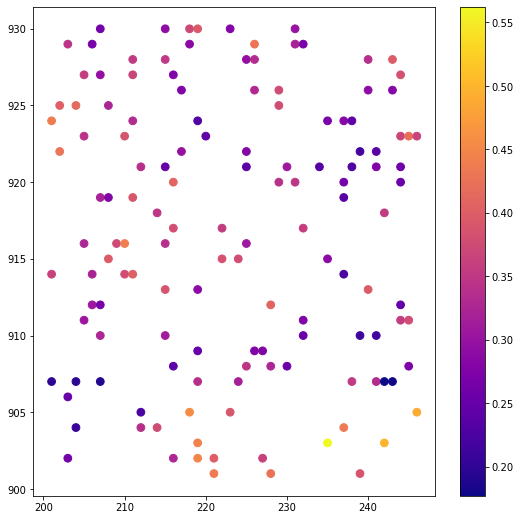

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(train.X,train.Y, s=60, c=train.NTG, cmap='plasma')
plt.colorbar(art)

По карте можно сделать предположение о том, что существуют наборы близкорасположенных скважин с примерно одинаковым значением целевого параметра (песчанистости). 

Проверим имеет ли целевой параметр нормальное распределение.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


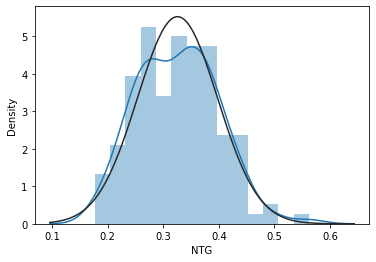

In [ ]:
sns.distplot(train['NTG'] , fit=norm, bins=14)

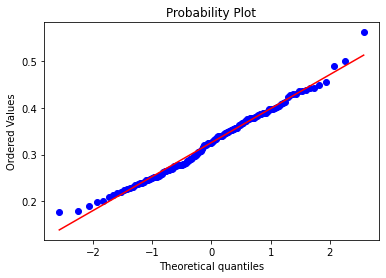

In [ ]:
fig = plt.figure()
res = stats.probplot(train['NTG'], plot=plt)
plt.show()

Можно сделать вывод, что распределение целевого параметра является близким к нормальному.

На этом исследование исходных данных заканчивается и переходим к проверке отдельных гипотез. 

Параметры моделей подбирались с помощью кросс-валидации, а также в отдельных случаях на сгенерированной вручную валидационной выборке. Некоторые модели работают на основе базовых параметров (по-умолчанию). Ниже представлены подходы решений и модели даны с уже подобранными параметрами.  

# 2. Кластеризация и усреднение

Суть метода заключается в разбиении исходного датасета на кластеры по координатам скважин. Используемый метод кластеризации - K-means. 

Подключение библиотек:

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

Чтение данных и исключение первого столбца ("Well" - имя скважины, является неинформативным признаком).

In [ ]:
train = pd.read_csv('Training_wells.csv')
test = pd.read_csv('Empty_part.csv')
train.drop('Well', axis=1, inplace=True)
test.drop('Well', axis=1, inplace=True)

Разбиение данных на 9 классов.

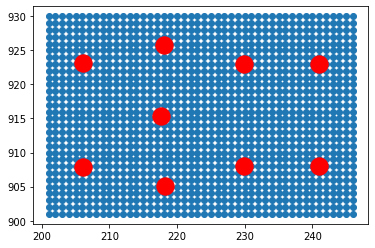

     X    Y     NTG  Class
0  201  907  0.2006      0
1  201  914  0.3624      0
2  201  924  0.4381      5
3  202  922  0.4289      5
4  202  925  0.4021      5


In [ ]:
n_train = train.shape[0]
n_test = test.shape[0]
clust_dataset = pd.concat((train, test))
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=0)
clust_dataset['Class'] = kmeans.fit_predict(clust_dataset[['X', 'Y']])
plt.scatter(clust_dataset['X'], clust_dataset['Y'])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()
print(clust_dataset.head())

Усреднение значений песчанистости внутри каждого класса.

In [ ]:
clust_dataset["NTG"] = clust_dataset.groupby("Class")["NTG"].transform(lambda x: x.fillna(x.mean()))

Проверим вид полученного датасета.

In [ ]:
print(clust_dataset)

        X    Y       NTG  Class
0     201  907  0.200600      0
1     201  914  0.362400      0
2     201  924  0.438100      5
3     202  922  0.428900      5
4     202  925  0.402100      5
...   ...  ...       ...    ...
1237  246  926  0.300853      2
1238  246  927  0.300853      2
1239  246  928  0.300853      2
1240  246  929  0.300853      2
1241  246  930  0.300853      2

[1380 rows x 4 columns]


Получение и присвоение значений целевой переменной для тестового датасета. 

In [ ]:
NTG = clust_dataset["NTG"][n_train:]
test['NTG'] = NTG

Проверим полученный тестовый датасет.

In [ ]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       1242 non-null   int64  
 1   Y       1242 non-null   int64  
 2   NTG     1242 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 29.2 KB
None


Построение тепловой карты всех скважин с учетом предсказанных значений песчанистости. 


     X    Y       NTG
0  201  901  0.284007
1  201  902  0.284007
2  201  903  0.284007
3  201  904  0.284007
4  201  905  0.284007


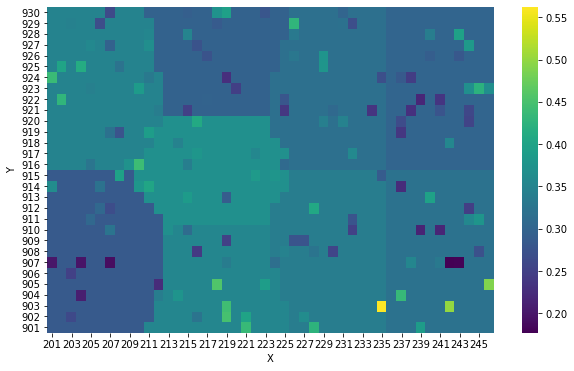

In [ ]:
plt.subplots(figsize=(10,6))
print(test.head())
full_data = pd.concat((train, test), ignore_index=True)
full_data = full_data.pivot("Y", "X", "NTG")
ax = sns.heatmap(full_data, cmap='viridis')
ax.invert_yaxis()

Сохранение датасета для загрузки на проверку. (С помощью данной секции был получен файл для первой проверки (submission1))

In [ ]:
# test.to_csv('submission1.csv', index=False)
# check = pd.read_csv('submission1.csv')
# print(check.head())
# print(test.head())
# print(test1.head())

# 3. Кригинг

Кригинг - геостатистический метод интерполяции, который использует статистические отношения между измеренными точками. 

При решении кейса с помощью кригинга использовались пакеты PyKrige и GSTools.

Установка пакетов для реализации кригинга.

Перед запуском скрипта нужно установить pykrige (pip install pykrige)

In [ ]:
# pip install pykrige

Перед запуском скрипта нужно установить gstools (pip install gstools)

In [ ]:
# pip install gstools

Подключение библиотек:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import seaborn as sns
import gstools as gs
import matplotlib.pyplot as plt

Чтение данных.

In [ ]:
train1 = pd.read_csv('Training_wells.csv')
train = train1.drop('Well', axis=1)
train = np.array(train)
test = pd.read_csv('Empty_part.csv')
test_copy = test.copy()

Зададим сетку всех возможных значений X и Y.

In [ ]:
gridx = np.arange(201, 247, 1)
gridy = np.arange(901, 931, 1)

Из пакета GSTools возьмем ковариационную модель (В зависимости от ковариационной модели получается разный результат и было загружено 6 результатов)

In [ ]:
cov_model = gs.Gaussian(dim=2, len_scale=4, anis=2, angles=-0.5, var=0.5, nugget=0.1) # Submission2
# cov_model = gs.Exponential(dim=2, len_scale=4, anis=1, angles=0.2, var=1, nugget=0.01) # Submission3
# cov_model = gs.Spherical(dim=2, len_scale=9, anis=1, angles=0.2, var=1, nugget=0.02) # Submission4
# cov_model = gs.Gaussian(dim=2, len_scale=5, anis=1, angles=0.2, var=1, nugget=0.03) # Submission5
# cov_model = gs.Gaussian(dim=2, len_scale=5, anis=1, angles=0.2, var=1, nugget=0.03) # Submission6 (UniversalKriging)


Интерполируем тренировочные данные с помощью кригинга (UniversalKriging/OrdinaryKriging) и получим значения песчанистости для тестового датасета. 

In [ ]:
OK1 = OrdinaryKriging(train[:, 0], train[:, 1], train[:, 2], cov_model)
result, ss1 = OK1.execute("grid", np.float64(gridx), np.float64(gridy))

test['NTG'] = np.nan
for i in range(0,test.shape[0]):
  test['NTG'][i] = result[test['Y'][i]-901][test['X'][i]-201]

Визуализируем полученный результат с помощью тепловой карты. 

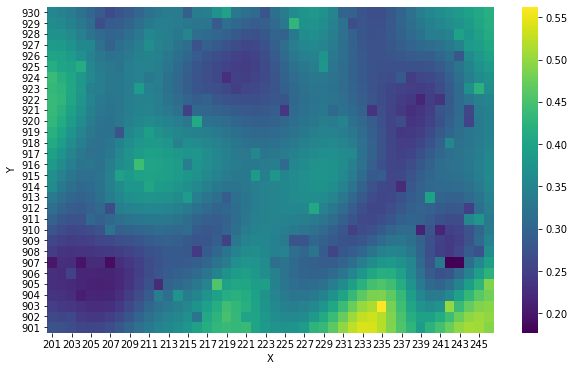

In [ ]:
plt.subplots(figsize=(10,6))
full_data = pd.concat((train1, test), ignore_index=True)
full_data = full_data.pivot("Y", "X", "NTG")
ax = sns.heatmap(full_data, cmap='viridis')
ax.invert_yaxis()

Сохранение результата в датасет для проверки на сайте.

In [ ]:
# test.to_csv('submission2_6.csv', index=False) #Номер сабмита зависит от ковариационной модели и типа кригинга
# check = pd.read_csv('submission2_6.csv')

# 4. Генерация новых признаков и использование классических методов

Исходный датасет содержит только два информативных параметра "X" и "Y". Так как это координаты, то можно создать дополнительные признаки с расстоянием от всех точек до точки №1 из тренировочного датасета, точки №2 и так далее до №138. Таким образом, получается 138 новых столбцов в датасете. К полученным данным применялись алгоритмы, приведенные ниже:


1.   RidgeRegression
2.   SVR (kernel='rbf') и SVR (kernel='linear')
3.   LGBM
4.   RandomForest
5.   Lasso (-)
6.   ElasticNet (-)

(-) Показали наименьшую эффективность и не использовались при получении результата для загрузки на сайт. 

Далее, для всех следующих моделей в качестве тренировочного датасета будет использоваться датасет с новым набором признаком (X, Y и 138 столбцов с расстояниями)

Подключение библиотек.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

Чтение данных

In [ ]:
dataset_train = pd.read_csv('Training_wells.csv')
dataset_test = pd.read_csv('Empty_part.csv')
train = dataset_train.copy()
test = dataset_test.copy()
check_test = dataset_test.copy()

Сгенерируем новые признаки для тренировочного датасета.

In [ ]:
new_columns = [str(x) for x in range(train.shape[0])]
for i in new_columns:
  train[i] = np.nan
  for j in range(train.shape[0]):
    train[i][j] = np.sqrt((train['X'][int(i)]-train['X'][int(j)]) ** 2 + (train['Y'][int(i)]-train['Y'][int(j)]) ** 2)

Сгенерируем новые признаки для тестового датасета.

In [ ]:
new_columns = [str(x) for x in range(train.shape[0])]
for i in new_columns:
  test[i] = np.nan
  for j in range(test.shape[0]):
    test[i][j] = np.sqrt((train['X'][int(i)]-test['X'][int(j)]) ** 2 + (train['Y'][int(i)]-test['Y'][int(j)]) ** 2)

Удалим первый признак и разделим тренировочный датасет для обучения модели.

In [ ]:
train.drop('Well', axis=1, inplace=True)
test.drop('Well', axis=1, inplace=True)
y = train['NTG']
X = train.drop('NTG', axis=1)

Сохраним датасеты с новыми признаками для ускорения работы последущих скриптов.

In [ ]:
# train.to_csv('Feature_train.csv', index=False)
# test.to_csv('Feature_test.csv', index=False)

Выполним нормировку данных с помощью StandardScaler() (для чувствительных к отсутствию нормировки моделей)

In [ ]:
# sc_X = StandardScaler()
# X = sc_X.fit_transform(X)
# test = sc_X.fit_transform(test)

Создадим и обучим модель, а также выполним предсказание песчанистости для тестового датасета.

In [ ]:
model = Ridge(alpha=0) #Submission7
# model = SVR(C=2, degree=2,epsilon=0.001, kernel='rbf') #Submission8
# model = LGBMRegressor(n_estimators=500, max_depth=4, num_leaves=7) #Submission9
# model = RandomForestRegressor()
model.fit(X, y)
predict = model.predict(test)

Визуализируем полученные данные с помощью тепловой карты.

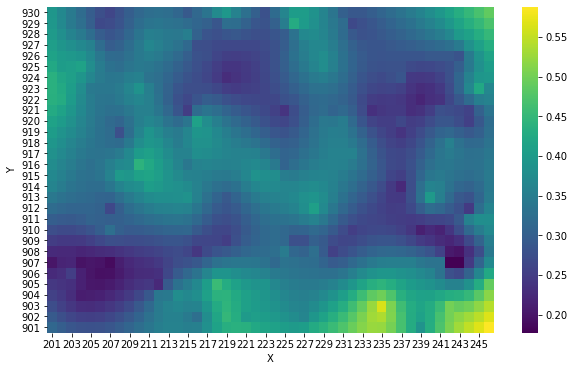

In [ ]:
predict = pd.Series(predict, name='NTG')
dataset_test = pd.concat((dataset_test, predict), axis=1)
full_data = pd.concat((dataset_train, dataset_test), ignore_index=True)
plt.subplots(figsize=(10,6))
full_data = full_data.pivot("Y", "X", "NTG")
ax = sns.heatmap(full_data, cmap='viridis')
ax.invert_yaxis()

Сохраним результат в файл для загрузки на сайт.

In [ ]:
# dataset_test.to_csv('submission7.csv', index=False)
# check = pd.read_csv('submission7.csv')
# print(check)
# print(dataset_train)
# print(check_test)

# 5. Stacking (с помощью мета-модели или модели второго уровня)

Stacking, в данной секции, заключается в предсказании песчанистости на простых моделях с последующим использованием результатов для получения итоговой песчанистости с помощью модели второго уровня. 

Подключение библиотек.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler

Чтение данных (считываем датасеты уже с созданными признаками для экономии времени)

In [ ]:
dataset_train = pd.read_csv('Feature_train.csv')
dataset_test = pd.read_csv('Feature_test.csv')
dataset_test_in = pd.read_csv('Empty_part.csv')
train = dataset_train.copy()
test = dataset_test.copy()
check_test = test.copy()

Разделим тренировочный датасет на признаки и таргет

In [ ]:
y = train['NTG']
X = train.drop('NTG', axis=1)

Нормировка данных

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(X)

Модели первого уровня.

In [ ]:
KRR = Ridge()
KNR = KNeighborsRegressor(weights = 'distance', n_neighbors=4)
GBoost = GradientBoostingRegressor(n_estimators=500, max_depth=4)

estimators = [
              ('ridge', KRR),
              ('GBoost', GBoost),
              ('KNR', KNR)]

Модель второго уровня.

In [ ]:
final_estimator = RandomForestRegressor(n_estimators=300, max_depth=4) #Submission11
# final_estimator = RandomForestRegressor(n_estimators=50, max_depth=3) #Submission12

Stacking с помощью модели второго уровня.

In [ ]:
model = StackingRegressor(estimators=estimators, 
                          final_estimator=final_estimator, 
                          cv=11)
model.fit(X, y)
scaler.transform(test)
predict = model.predict(test)


Визуализация результата работы двухуровневой модели.

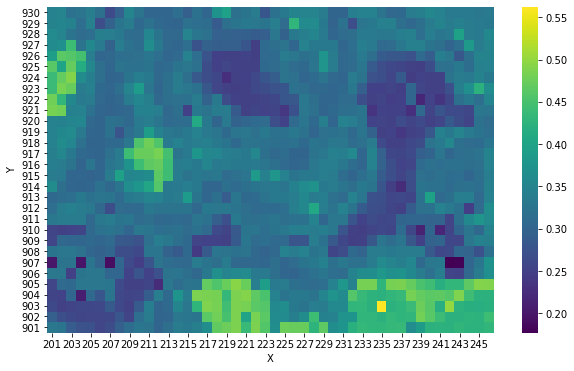

In [ ]:
predict = pd.Series(predict, name='NTG')
dataset_test_in = pd.concat((dataset_test_in, predict), axis=1)
full_data = pd.concat((dataset_train, dataset_test_in), ignore_index=True)
plt.subplots(figsize=(10,6))
full_data = full_data.pivot("Y", "X", "NTG")
ax = sns.heatmap(full_data, cmap='viridis')
ax.invert_yaxis()

# Регрессионный кригинг

Также реализован с помощью пакета PyKrige.

Подключение библиотек.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from pykrige.rk import RegressionKriging
from sklearn.linear_model import Ridge
import seaborn as sns
from pykrige.compat import train_test_split

Чтение данных.

In [ ]:
dataset_train = pd.read_csv('Feature_train.csv')
dataset_test = pd.read_csv('Feature_test.csv')
dataset_test_in = pd.read_csv('Empty_part.csv')
train = dataset_train.copy()
test = dataset_test.copy()
check_test = test.copy()

Разделение тренировочного датасета на признаки и целевую переменную.

In [ ]:
y = train['NTG']
X = train.drop('NTG', axis=1)

Зададим массивы входных данных для модели.

In [ ]:
x = np.float64(np.array(X.iloc[:, :2]))
p = np.float64(np.array(X.iloc[:,2:]))
target = np.float64(np.array(y))

real_x = np.float64(np.array(test.iloc[:, :2]))
real_p = np.float64(np.array(test.iloc[:,2:]))

Создание модели регрессионного кригинга с помощью SVR.

In [ ]:
# model = SVR(C=2, epsilon=0.001, kernel='rbf') #Submission13
# model = LGBMRegressor(n_estimators=200, max_depth=2, num_leaves=2) #Submission14
# model = RandomForestRegressor() #Submission17
model = Ridge(alpha=3) #Submission15
model2 = RegressionKriging(regression_model=model,
                            n_closest_points=3)
model2.fit(p, x, y)
predict = model2.predict(real_p, real_x)

Визуализация результата.

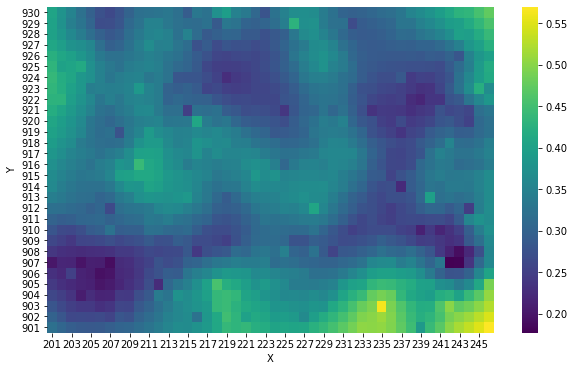

In [ ]:
predict = pd.Series(predict, name='NTG')
dataset_test_in = pd.concat((dataset_test_in, predict), axis=1)
full_data = pd.concat((dataset_train, dataset_test_in), ignore_index=True)
plt.subplots(figsize=(10,6))
full_data = full_data.pivot("Y", "X", "NTG")
ax = sns.heatmap(full_data, cmap='viridis')
ax.invert_yaxis()

Сохранение датасета для проверки на сайте.

In [ ]:
# dataset_test_in.to_csv('submission15.csv', index=False)
# check = pd.read_csv('submission15.csv')
# print(check.head())
# print(dataset_test_in.head())
# tt = pd.read_csv('Training_wells.csv')
# print(tt.head())

# Простейший Stacking (усреднение результатов различных моделей)

Производится усреднение результатов предсказаний различных моделей. 

Для усреднения из предыдущих результатов (файлов submission 1-15,17) берется целевой столбец и усредняется по количеству выбранных моделей (для некоторых моделей были выбраны весовые коэффициенты). 
Так получены результаты для попыток номер 16,18,20.

В качестве попытки номер 16 был загружен результат усреднения моделей Kriging (cov_model = gs.Spherical)(submission4), Ridge Regression (submission7), SVR (submission8), RegressionKriging с SVR (submission13)

В качестве попытки номер 18 был загружен результат усреднения моделей Ridge Regression (submission7), Kriging (cov_model Gaussian)(submission5), RegressionKriging с Ridge (submission15), RegressionKriging с SVR (submission13) и RegressionKriging с LGBMRegressor (submission14). 

В качестве попытки номер 20 был загружен результат усреднения моделей Kriging (cov_model Gaussian)(submission5) и результат усреднения (submission16)